In [1]:
import pandas as pd
import glob
from altair import sample 
import natsort
from sklearn.metrics import roc_auc_score
import numpy as np

score_df_paths_same = glob.glob('../scoring_results/same/*.csv')
score_df_paths_same = natsort.natsorted(score_df_paths_same)

from pprint import pprint
pprint(score_df_paths_same)

TEMPERATURES = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,]

['../scoring_results/same/same_query_temperature_0.01_sample_n_30_11_22_02_12_28_results.csv',
 '../scoring_results/same/same_query_temperature_0.05_sample_n_30_11_21_17_33_50_results.csv',
 '../scoring_results/same/same_query_temperature_0.10_sample_n_30_01_17_13_14_55_results.csv',
 '../scoring_results/same/same_query_temperature_0.20_sample_n_30_01_17_08_06_13_results.csv',
 '../scoring_results/same/same_query_temperature_0.30_sample_n_30_11_21_08_41_52_results.csv',
 '../scoring_results/same/same_query_temperature_0.40_sample_n_30_01_18_07_06_54_results.csv',
 '../scoring_results/same/same_query_temperature_0.50_sample_n_30_11_21_01_50_46_results.csv',
 '../scoring_results/same/same_query_temperature_0.60_sample_n_30_01_18_14_45_30_results.csv',
 '../scoring_results/same/same_query_temperature_0.70_sample_n_30_11_20_00_56_40_results.csv',
 '../scoring_results/same/same_query_temperature_0.80_sample_n_30_01_19_14_09_00_results.csv',
 '../scoring_results/same/same_query_temperature_0

In [2]:

def extract_label_and_scores(df:pd.DataFrame):

    df  = df[['qid','factuality','pr_score','re_score','f1_score','question']]
    
    label_and_scores = {
        'label':[],
        'pr':[],
        're':[],
        'f1':[]
    }
    
    # set data type
    # df['factuality'] = df['factuality'].astype(str)
    
    for i in range(df.shape[0]):
        df.iloc[i]['factuality'] = str(df.iloc[i]['factuality'])
    
    for i in range(df.shape[0]):
        labels = df.iloc[i]['factuality'].split(',')
        pr_scores = df.iloc[i]['pr_score'].split(',')
        re_scores = df.iloc[i]['re_score'].split(',')
        f1_scores = df.iloc[i]['f1_score'].split(',')
        
        labels = [1 - int(x) for x in labels]
        pr_scores = [float(x) for x in pr_scores]
        re_scores = [float(x) for x in re_scores]
        f1_scores = [float(x) for x in f1_scores]
        
        assert len(labels) == len(pr_scores), f"labels: {labels}, pr_scores: {pr_scores},i: {i},q: {df.iloc[i]['question']}"
        
        label_and_scores['label'].extend(labels)
        label_and_scores['pr'].extend(pr_scores)
        label_and_scores['re'].extend(re_scores)
        label_and_scores['f1'].extend(f1_scores)
    
    import numpy as np
    label_and_scores["label"] = np.array(label_and_scores["label"])
    label_and_scores["pr"] = np.array(label_and_scores["pr"])
    label_and_scores["re"] = np.array(label_and_scores["re"])
    label_and_scores["f1"] = np.array(label_and_scores["f1"])
    

    return label_and_scores


def calc_auc_roc(df:pd.DataFrame):
    
    label_and_scores = extract_label_and_scores(df.copy())

    roc_aucs = {
        'pr':roc_auc_score(label_and_scores['label'],label_and_scores['pr']),
        're':roc_auc_score(label_and_scores['label'],label_and_scores['re']),
        'f1':roc_auc_score(label_and_scores['label'],label_and_scores['f1']),
        "ave":roc_auc_score(label_and_scores['label'],(label_and_scores['pr'] + label_and_scores['re'] + label_and_scores['f1'])/3),
        'random' : roc_auc_score(label_and_scores['label'],np.random.rand(len(label_and_scores['label']))),
    }

    return roc_aucs['pr']



In [3]:
samples_vs_auc_same = {}

for i, path in enumerate(score_df_paths_same):
    df = pd.read_csv(path)
    # print(f"length: {LENGTHS[i]}, auc: {calc_auc_roc(df.copy())}")
    auc = calc_auc_roc(df.copy())
    samples_vs_auc_same[TEMPERATURES[i]] = auc
from pprint import pprint
pprint(samples_vs_auc_same) 


    


{0.01: 0.490364277320799,
 0.05: 0.6174206815511164,
 0.1: 0.6722385428907167,
 0.2: 0.7007931844888368,
 0.3: 0.7204465334900116,
 0.4: 0.7300822561692127,
 0.5: 0.7507931844888366,
 0.6: 0.7472972972972974,
 0.7: 0.7668625146886017,
 0.8: 0.7660399529964748,
 0.9: 0.7689776733254994}


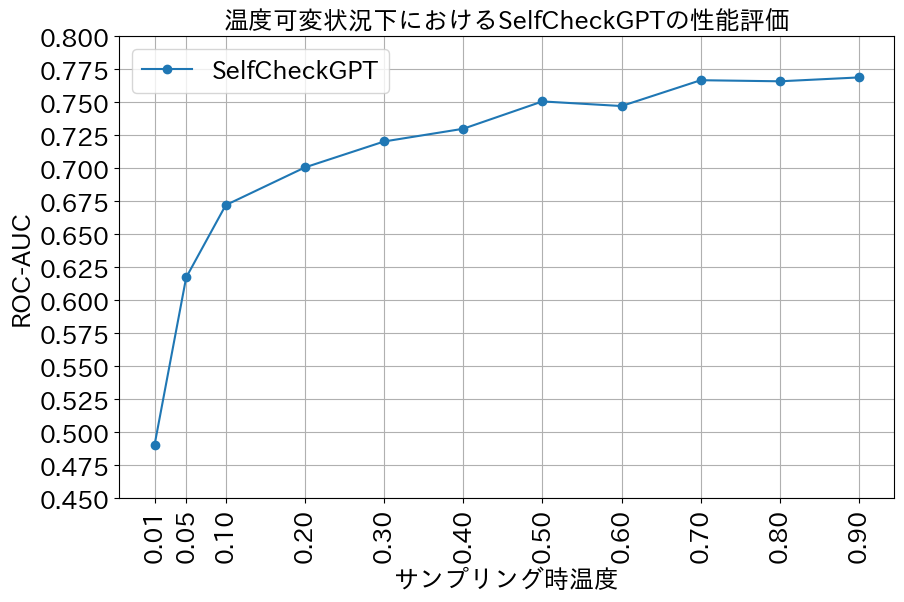

In [5]:
# graphにする
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib


# Data
string_lengths_same = samples_vs_auc_same.keys()
roc_auc_values_same =  samples_vs_auc_same.values()





#上から性能いい順に凡例をつけると視線誘導できて分かりやすい
font_size = 18
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(string_lengths_same, roc_auc_values_same, marker='o',)
plt.title('温度可変状況下におけるSelfCheckGPTの性能評価', fontsize=font_size)
plt.xlabel('サンプリング時温度', fontsize=font_size)

plt.ylabel('ROC-AUC', fontsize=font_size)
plt.xticks(list(string_lengths_same),fontsize=font_size, rotation=90)
plt.yticks([0.45,0.475,0.50,0.525,0.55,0.575,0.60,0.625,0.65,0.675,0.70,0.725,0.75,0.775,0.800],fontsize=font_size)
plt.ylim(0.45, 0.80)
plt.grid(True)



# plt.axhline(y=0.7707692307692308, color='g', linestyle='--')
plt.legend(['SelfCheckGPT'], fontsize=font_size)


# 最高性能のところを→で示す
# plt.annotate('AUC-ROC 0.714', xy=(600, 0.7147), xytext=(700, 0.71),
#              arrowprops=dict(facecolor='black', shrink=0.01,width=1),
#              fontsize=font_size / 1.3)



plt.show()


